## Chapter 2-6, 1강 NLP 텍스트 분류 — 전통 ML(TF‑IDF) vs 임베딩(SBERT)

- 목표: 전통 특성공학(TF‑IDF+선형모델)과 문장 임베딩(SBERT)+얕은 분류기를 CPU 환경에서 비교
- 데이터: 뉴스 분류(AG News) 또는 영화평(IMDb) 소규모 서브샘플
- 규칙(강의용): matplotlib만 사용, 최소 시각화(혼동행렬), 간결한 데모 셀


### 구성 (Overview)
- 전처리/샘플링 → TF‑IDF+로지스틱 → SBERT 임베딩+로지스틱 → 성능/속도 비교 → 오류사례 확인 → 간단 데모


### 0. 환경 설정 및 라이브러리


In [29]:
# =========================
# 0. 환경 설정 및 라이브러리
# =========================

# 표준 라이브러리
import os, time, random, math  # (필요 시 사용) 파일/시간/난수/수학 관련 유틸
from typing import Tuple, List  # 타입 힌트

# 서드파티: 수치/데이터/시각화
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 서드파티: 사이킷런(전처리/모델/평가/차원축소)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score
)
from sklearn.decomposition import PCA

# 경고 필터링(특정 환경에서 발생하는 matmul 관련 워닝 억제)
import warnings
warnings.filterwarnings("ignore", message=".*matmul.*")

# 임베딩 생성을 위한 SBERT 모델
from sentence_transformers import SentenceTransformer
# 공개 데이터셋 로딩을 위한 HuggingFace datasets 
from datasets import load_dataset


# -----------------------------------------
# Matplotlib: 한글 폰트 및 마이너스 기호 설정
# -----------------------------------------
# macOS 기준 AppleGothic 사용. 환경에 맞게 교체 가능.
plt.rcParams["font.family"] = "AppleGothic"
# 축/주석에서 음수 부호가 네모로 깨지지 않도록 처리
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
# ------------------------
# 재현성(시드) 고정 유틸
# ------------------------
def set_seed(seed: int = 42) -> None:
    """
    랜덤 시드를 고정하여 실험 재현성을 확보합니다.
    - random: 파이썬 기본 난수
    - numpy: 수치 연산 난수
    (필요 시 torch, tensorflow 등도 함께 고정하세요.)
    """
    random.seed(seed)
    np.random.seed(seed)

# 스크립트 로드 시 기본 시드 42로 고정
set_seed(42)


SBERT 사용 가능: True
HuggingFace datasets 사용 가능: True


### 1. 데이터 준비 및 샘플링
- AG News(4클래스) 또는 IMDb(2클래스)에서 소규모 서브샘플
- 실습 편의를 위해 `datasets` 라이브러리를 사용, 없으면 간단 더미 데이터로 대체


In [23]:
# =========================
# 유틸: 간단 타이머 데코레이터
# =========================
from contextlib import contextmanager

@contextmanager
def timer(msg: str):
    """
    코드 블록 실행 시간을 측정하는 context manager.
    
    사용 예시:
    -----------------
    with timer("모델 학습"):
        model.fit(X_train, y_train)

    출력 예시:
    [TIME] 모델 학습: 0.53s
    -----------------

    Args:
        msg (str): 어떤 작업을 측정하는지 표시할 설명 문자열
    """
    t0 = time.perf_counter()     # 시작 시점(고해상도 타이머)
    yield                        # with 블록 내부 코드 실행
    elapsed = time.perf_counter() - t0
    print(f"[TIME] {msg}: {elapsed:.2f}s")


In [ ]:
# 전역 변수: 라벨 이름 리스트 (load 함수에서 채워짐)
label_names: List[str] = []


# -------------------------
# 환경 변수 기반 옵션 설정
# -------------------------
# NLP_DATASET 환경 변수에서 데이터셋 이름 가져오기 (기본값: "ag_news")
# - "ag_news": 뉴스 기사 분류(4클래스)
# - "imdb": 감성 분류(2클래스) → 향후 확장 대비
DATASET = os.environ.get("NLP_DATASET", "ag_news") 

# # 클래스별 샘플 개수 (기본: 250개, AG News용)
# N_PER_CLASS = int(os.environ.get("N_PER_CLASS", 250))

# 학습/테스트 데이터 분할 비율
TEST_SIZE = 0.2



def load_ag_news_subset(n_per_class: int = 250) -> Tuple[List[str], List[int]]:
    """
    AG News 데이터셋에서 클래스별로 동일 개수 샘플링하여 서브셋을 로드합니다.
    HuggingFace datasets가 없으면 더미 데이터(2클래스)를 반환합니다.

    Args:
        n_per_class (int): 클래스당 샘플 개수 (기본값=250)

    Returns:
        texts (List[str]): 기사 텍스트 리스트
        labels (List[int]): 정수형 라벨 리스트
    """

    global label_names

    # -------------------------
    # HF datasets의 AG News 로드
    # -------------------------
    ds = load_dataset("ag_news", split="train")  # 전체 120k train 데이터 로드
    label_names = ["World", "Sports", "Business", "Sci/Tech"]  # 공식 라벨명 (4클래스)

    xs, ys = [], []
    for lab in range(4):
        # 각 라벨별 데이터에서 n_per_class 만큼 샘플 추출
        sub = ds.filter(lambda ex: ex["label"] == lab).select(range(n_per_class))
        xs += [r["text"] for r in sub]             # 기사 텍스트 모으기
        ys += [int(r["label"]) for r in sub]       # 정수 라벨 모으기

    return xs, ys



In [ ]:
def load_imdb_subset(n_total: int = 2000) -> Tuple[List[str], List[int]]:
    """
    IMDb 영화 리뷰 데이터셋에서 긍정/부정 리뷰를 균등 샘플링하여 로드합니다.
    (HuggingFace datasets 필요)

    Args:
        n_total (int): 가져올 총 샘플 수 (기본=2000, 즉 각 클래스 1000개)

    Returns:
        xs (List[str]): 리뷰 텍스트 리스트
        ys (List[int]): 라벨 리스트 (0=부정, 1=긍정)
    """
    global label_names
    label_names = ["neg", "pos"]   # IMDb 공식 라벨명 (0=부정, 1=긍정)

    # -------------------------
    # IMDb 전체 데이터 로드 (50k 샘플: train 25k + test 25k)
    # -------------------------
    ds = load_dataset("imdb")

    # train split에서만 균등 샘플링 (25k 샘플)
    train = ds["train"]

    # 긍정(1)과 부정(0) 리뷰에서 각각 n_total/2 만큼 추출
    pos = train.filter(lambda ex: ex["label"] == 1).select(range(n_total // 2))
    neg = train.filter(lambda ex: ex["label"] == 0).select(range(n_total // 2))

    # -------------------------
    # 텍스트와 라벨 리스트 구성
    # -------------------------
    xs = [r["text"] for r in pos] + [r["text"] for r in neg]    # 리뷰 텍스트
    ys = [1] * len(pos) + [0] * len(neg)                       # 긍정=1, 부정=0

    # -------------------------
    # 셔플 (긍/부정 섞기)
    # -------------------------
    idx = np.arange(len(xs))
    np.random.shuffle(idx)
    xs = [xs[i] for i in idx]
    ys = [ys[i] for i in idx]

    return xs, ys

In [ ]:
# =========================
# 데이터 로딩
# =========================

# 선택된 데이터셋에 따라 로딩 방식 분기
if DATASET == "imdb":
    # IMDb → 총 n_total 샘플 균등 추출 (기본 2000개: 긍/부정 1000개씩)
    X_text, y = load_imdb_subset(n_total=2000)
else:
    # AG News → 클래스별 n_per_class 샘플 균등 추출 (기본 250개씩, 총 1000개)
    X_text, y = load_ag_news_subset(n_per_class=250)

# 데이터 크기 및 라벨 정보 확인
print(len(X_text), "samples, labels=", sorted(set(y)))
print("label_names:", label_names)


# =========================
# Train / Validation 분할
# =========================
# - stratify=y: 클래스 비율을 유지하면서 분할 (불균형 데이터 대비)
# - test_size: 검증용 데이터 비율 (기본 0.2 → 80% 학습 / 20% 검증)
# - random_state: 재현성 보장
X_train, X_val, y_train, y_val = train_test_split(
    X_text, y,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y
)


1000 samples, labels= [0, 1, 2, 3]
label_names: ['World', 'Sports', 'Business', 'Sci/Tech']


In [32]:
# -------------------------
# 클래스별 샘플 문장 출력
# -------------------------
print("\n[클래스별 샘플 예시]")

# 각 클래스별로 몇 개 출력했는지 카운트하는 딕셔너리
per_class_shown = {c: 0 for c in set(y)}

# 전체 텍스트와 라벨을 순회하면서, 클래스별로 2개씩만 출력
for txt, lab in zip(X_text, y):
    if per_class_shown[lab] < 2:
        # 라벨명 + 앞 120글자만 잘라서 표시
        print(f"[{label_names[lab]}] {str(txt)[:120]}...")
        per_class_shown[lab] += 1



[클래스별 샘플 예시]
[World] Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large number...
[World] S.Koreans Clash with Police on Iraq Troop Dispatch (Reuters) Reuters - South Korean police used water cannon in\central ...
[Sports] Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter frees...
[Sports] Reds Knock Padres Out of Wild-Card Lead (AP) AP - Wily Mo Pena homered twice and drove in four runs, helping the Cincinn...
[Business] Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics,...
[Business] Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputat...
[Sci/Tech] 'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the...
[Sci/Tech] Group to Propose New High-Speed Wireless

### 2. TF-IDF 파이프라인 — TF‑IDF + 로지스틱 회귀


#### TF-IDF (Term Frequency – Inverse Document Frequency)

TF-IDF는 **특정 단어가 한 문서에서 얼마나 중요한지**를 수치화하는 방법입니다.  
"많이 등장하지만 모든 문서에 흔한 단어"는 중요하지 않고,  
"특정 문서에만 두드러지게 등장하는 단어"에 높은 가중치를 줍니다.  

---
##### 1. 구성 요소

- **TF (Term Frequency, 단어 빈도)**  
  문서 \(d\)에서 단어 \(t\)가 얼마나 자주 등장하는지  

  $$
  TF(t, d) = \frac{\text{단어 } t \text{의 빈도}}{\text{문서 } d \text{의 전체 단어 수}}
  $$

- **IDF (Inverse Document Frequency, 역문서 빈도)**  
  단어가 전체 문서 집합에서 얼마나 희귀한지를 나타냄  

  $$
  IDF(t) = \log \frac{N}{1 + df(t)}
  $$

  - \(N\): 전체 문서 수  
  - \(df(t)\): 단어 \(t\)가 등장한 문서 수  

- **TF-IDF**  

  $$
  TF\text{-}IDF(t, d) = TF(t, d) \times IDF(t)
  $$


---

##### 2. 직관적인 예시
- 스포츠 기사에서:  
  - `"경기"` → 해당 기사에서 자주 나오고 다른 주제에는 잘 안 나옴 → 높은 TF-IDF  
  - `"오늘"` → 모든 기사에 흔하게 등장 → 낮은 TF-IDF  

---

##### 3. 특징 & 한계
**장점**  
- 구현이 간단하고 빠르다  
- 뉴스/리뷰 분류 같은 전통 텍스트 마이닝에서 강력한 baseline  

**한계**  
- 단어 순서(문맥)를 반영하지 못함  
- 동의어/다의어 문제(`car` vs `automobile`)에 약함  
- 고차원 희소 벡터 → 메모리 부담  

---


In [33]:
# -------------------------
# 1) 텍스트 벡터화: TF-IDF
# -------------------------
# - max_features=30000: 상위 30k 단어/bi-gram만 사용
# - ngram_range=(1,2): unigram + bigram 특징을 함께 반영
vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 2))

# 학습 데이터에 대해 TF-IDF 행렬 학습 및 변환
with timer("TF-IDF fit_transform"):
    Xtr = vectorizer.fit_transform(X_train)

# 검증 데이터는 학습된 vectorizer로만 변환 (fit은 하지 않음)
with timer("TF-IDF transform(val)"):
    Xva = vectorizer.transform(X_val)

# 결과 확인
print("TF-IDF 벡터 shape:", Xtr.shape)  
# → (샘플 수, 피처 수) 크기의 희소 행렬
print("희소 행렬 밀도:", round(Xtr.nnz / (Xtr.shape[0] * Xtr.shape[1]), 6))  
# → nnz: non-zero 값 개수 / 전체 원소 개수 → 얼마나 sparse 한지 확인


[TIME] TF-IDF fit_transform: 0.16s
[TIME] TF-IDF transform(val): 0.02s
TF-IDF 벡터 shape: (800, 28755)
희소 행렬 밀도: 0.00247


In [44]:

# -------------------------
# 2) 로지스틱 회귀 모델 학습
# -------------------------
clf_tfidf = LogisticRegression(max_iter=200, n_jobs=-1)#, multi_class="ovr")
clf_tfidf.fit(Xtr, y_train)

# - max_iter=200: 학습 반복 횟수 제한
# - n_jobs=None: 단일 프로세스로 실행 (병렬처리 원하면 -1)

with timer("TF-IDF+LR 학습"):
    clf_tfidf.fit(Xtr, y_train)



[TIME] TF-IDF+LR 학습: 0.22s


In [41]:
# -------------------------
# 3) 모델 검증 및 성능 평가
# -------------------------
# 검증 데이터 예측
pred_tfidf = clf_tfidf.predict(Xva)

# 정확도 계산
acc_tfidf = accuracy_score(y_val, pred_tfidf)
print(f"TF-IDF+LR | acc={acc_tfidf:.3f}")

# 클래스별 정밀도/재현율/F1-score 출력
print(classification_report(y_val, pred_tfidf, target_names=label_names))


TF-IDF+LR | acc=0.845
              precision    recall  f1-score   support

       World       0.89      0.78      0.83        50
      Sports       0.80      0.98      0.88        50
    Business       0.88      0.72      0.79        50
    Sci/Tech       0.83      0.90      0.87        50

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



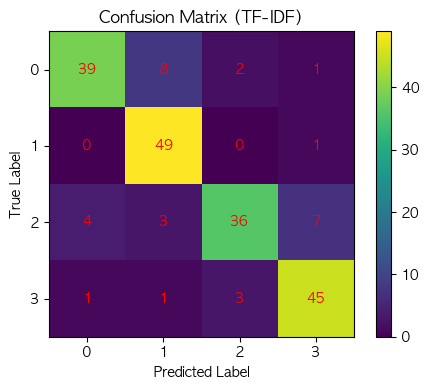

In [45]:
# =========================
# 혼동 행렬 (Confusion Matrix) 시각화
# =========================

# 혼동 행렬 계산
cm_tfidf = confusion_matrix(y_val, pred_tfidf)

# Figure 크기 설정
plt.figure(figsize=(5, 4))

# 혼동 행렬을 이미지(heatmap)처럼 출력
plt.imshow(cm_tfidf, cmap="viridis")
plt.title("Confusion Matrix (TF-IDF)")  # 제목
plt.colorbar()  # 색상바 추가 → 값 크기 직관적으로 확인 가능

# 축 라벨 설정 (0 ~ 클래스 수-1)
classes = range(cm_tfidf.shape[0])
plt.xticks(classes, classes)  # X축 (예측 클래스)
plt.yticks(classes, classes)  # Y축 (실제 클래스)

# 축 이름 붙이기
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 셀 안 숫자 출력
for i in range(cm_tfidf.shape[0]):
    for j in range(cm_tfidf.shape[1]):
        plt.text(j, i, str(cm_tfidf[i, j]),
                 ha='center', va='center', color="red")
# 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()


#### 혼동행렬 결과 해석

##### 클래스별 성능
- **클래스 0 (World)**
  - 39개를 올바르게 맞춤
  - 8개는 클래스 1(Sports)으로 잘못 분류
  - 2개는 클래스 2(Business), 1개는 클래스 3(Sci/Tech)으로 오분류

- **클래스 1 (Sports)**
  - 49개를 정확히 맞춤
  - 단 1개만 클래스 3으로 잘못 예측 → 거의 완벽

- **클래스 2 (Business)**
  - 38개 정답
  - 3개는 클래스 0, 3개는 클래스 1, 6개는 클래스 3으로 혼동

- **클래스 3 (Sci/Tech)**
  - 45개 정답
  - 소수(1~3개)는 다른 클래스와 혼동

---

##### 성능 요약
- **Sports(1)**: 거의 완벽하게 구분됨 (오차 1개)  
- **World(0)**: 일부를 Sports/Business와 혼동 → 경계가 애매한 기사 존재  
- **Business(2)**: 다른 클래스와 혼동이 가장 많음 (특히 Sci/Tech와 혼동)  
- **Sci/Tech(3)**: 대체로 잘 맞추지만, 일부는 Business/World로 오분류  

---

##### 인사이트
- 전반적으로 **TF-IDF + 로지스틱 회귀가 높은 정확도**를 보여줌  
- 다만 **Business ↔ Sci/Tech** 기사 간 구분이 상대적으로 어려움  
  - 실제로 단어 분포가 비슷할 수 있음 (예: *“기술 기업의 비즈니스 전략”* 같은 문장)  
- 더 정교한 임베딩(예: **SBERT, BERT**)을 사용하면 문맥적 의미까지 반영되어 구분력이 개선될 가능성이 큼


In [46]:
# =========================
# 클래스별 상위 특징 단어 출력 함수
# =========================
def top_features(clf: LogisticRegression, vectorizer: TfidfVectorizer, n: int = 10):
    names = vectorizer.get_feature_names_out()
    coef = clf.coef_

    # 다중분류: coef_.shape == (n_classes, n_features)
    if coef.ndim == 2 and coef.shape[0] > 1:
        # 모델이 내부적으로 사용하는 클래스 순서에 맞춰 라벨 이름 매핑
        class_labels = [label_names[c] for c in clf.classes_]
        for i, lab in enumerate(class_labels):
            idx = np.argsort(coef[i])[-n:]
            print(lab, ":", [names[j] for j in idx])
    else:
        # 이진분류: coef_.shape == (1, n_features)
        idx = np.argsort(np.abs(coef.ravel()))[-n:]
        print("Top features:", [names[j] for j in idx])


# 실행부
print("\n[클래스별 상위 특징 단어 — TF-IDF]")
try:
    top_features(clf_tfidf, vectorizer, n=10)
except Exception as e:
    # 예외 발생 시 스킵 (예: 아직 모델이 학습되지 않았을 경우)
    print("(상위 특징 추출 스킵)", e)



[클래스별 상위 특징 단어 — TF-IDF]
World : ['iraqi', 'said', 'chavez', 'bush', 'president', 'najaf', 'troops', 'afp', 'in', 'iraq']
Sports : ['gold', 'the', '39', 'his', 'win', 'athens reuters', 'ap', 'olympic', 'team', 'athens']
Business : ['oil prices', 'stocks', 'inc', 'google', 'company', 'profit', 'reuters', 'prices', 'its', 'oil']
Sci/Tech : ['experts', 'that', 'com', 'of', 'gt', 'lt', 'ap', 'space com', 'scientists', 'space']


### 3. SBERT 파이프라인 — SBERT + 로지스틱

#### SBERT (Sentence-BERT) 이론적 배경

##### 1. BERT와 문장 임베딩의 한계
- **BERT(Bidirectional Encoder Representations from Transformers)** 는 문장 수준의 의미를 잘 학습하지만,
  원래 목적은 **마스크드 언어모델(MLM)**, **다음 문장 예측(NSP)** 과 같은 사전학습 과제.
- 따라서 문장을 임베딩으로 변환할 때는 [CLS] 토큰 벡터를 사용하지만,
  - 문장 간 의미적 유사도 계산에 최적화되지 않음
  - 연산량이 많아 **대규모 문장 쌍 비교**에는 비효율적임

##### 2. SBERT의 아이디어
- SBERT(Sentence-BERT)는 **BERT 구조를 문장 임베딩용으로 재학습**한 모델.
- 핵심 아이디어:
  - **Siamese Network 구조** 사용  
    → 동일한 BERT를 공유하는 두 개의 인코더가 입력 문장 쌍을 각각 임베딩으로 변환
  - 그 임베딩을 **코사인 유사도(Cosine Similarity)** 로 비교
- 이렇게 하면 **문장 간 의미적 유사도**를 효율적으로 계산 가능

##### 3. 장점
- **효율성**: 모든 문장을 임베딩해둔 뒤, 벡터 간 코사인 유사도 계산만 하면 되므로 검색·분류가 매우 빠름  
- **성능 향상**: TF-IDF, 평균 Word2Vec 등 단순 방법보다 문맥과 의미를 더 잘 반영  
- **범용성**: 분류, 검색, 군집화, 의미 유사도 계산 등 다양한 NLP 다운스트림 태스크에 활용 가능  

##### 4. 직관적 이해
- TF-IDF: 단어 등장 빈도로 문서 표현 (문맥 반영 X)  
- SBERT: Transformer 기반 문맥 표현을 문장 수준 임베딩으로 변환 (문맥 반영 O)  

---


In [ ]:
def sbert_encode(
    texts: List[str],
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2",
    batch_size: int = 64
):
    """
    SBERT 임베딩 생성 함수.
    - SentenceTransformer 모델을 사용해 입력 텍스트들을 벡터로 변환합니다.
    - 안전성을 위해 직접 L2 정규화 수행 + NaN/Inf 값 방지 처리.

    Args:
        texts (List[str]): 입력 텍스트 리스트
        model_name (str): SBERT 모델명 (기본=MiniLM-L6-v2)
        batch_size (int): 배치 단위로 나눠서 인코딩 (기본=64)

    Returns:
        np.ndarray: (num_texts, embedding_dim) 크기의 임베딩 행렬
    """

    # 입력 클린업: None 또는 빈 문자열은 특수 토큰으로 대체
    _texts = [t if (isinstance(t, str) and t.strip()) else "[EMPTY]" for t in texts]

    # SBERT 모델 로드 (CPU 강제)
    model = SentenceTransformer(model_name, device="cpu")

    arrs = []
    for i in range(0, len(_texts), batch_size):
        # SBERT 임베딩 계산 (정규화는 직접 수행)
        arr = model.encode(
            _texts[i:i+batch_size],
            batch_size=batch_size,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=False,   # 직접 정규화할 것이므로 False
        ).astype(np.float64)

        # -------------------------
        # L2 정규화 수행
        # -------------------------
        # 각 문장 벡터(arr[i])의 길이(norm)를 계산한 후,
        # 그 길이로 나누어 모든 벡터의 길이를 1로 맞춤.
        # -> 코사인 유사도 계산 시 스케일 차이를 없애고 안정적인 비교 가능.
        # np.clip(..., 1e-12, None)은 norm이 0일 경우 0으로 나누는 것을 방지하는 안전장치.
        norms = np.linalg.norm(arr, axis=1, keepdims=True)
        arr = arr / np.clip(norms, 1e-12, None)

        # -------------------------
        # NaN / Inf 값 방지 처리
        # -------------------------
        # SBERT 인코딩 결과가 비정상적일 때(빈 입력 등)
        # NaN(Not a Number), +Inf, -Inf 값이 발생할 수 있음.
        # np.nan_to_num을 통해 이런 값을 모두 0.0으로 치환하여
        # 학습/추론 과정이 중단되지 않도록 안전성 확보.
        arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)


        arrs.append(arr)

    out = np.vstack(arrs)  # 배치 단위 결과를 하나의 행렬로 합침
    return out

[TIME] SBERT 임베딩 생성(train+val): 37.55s


In [48]:
# -------------------------
# Train/Val 데이터 임베딩 생성
# -------------------------
with timer("SBERT 임베딩 생성(train+val)"):
    Xtr_emb = sbert_encode(X_train)  # 학습 데이터 임베딩
    Xva_emb = sbert_encode(X_val)    # 검증 데이터 임베딩

[TIME] SBERT 임베딩 생성(train+val): 38.96s


In [50]:
# =========================
# 비정상 행 탐지 (디버깅 로그)
# =========================
# - np.isfinite: 유한한 값(True/False) 판별 (NaN/±Inf → False)
# - ~np.isfinite(...): 비정상 값 위치(True) 마스크
# - np.sum(...) : 전체 벡터 중 비정상 값 개수 집계
_bad_train = np.sum(~np.isfinite(Xtr_emb))
_bad_val = np.sum(~np.isfinite(Xva_emb))

# 만약 train/val 임베딩에 비정상 값이 하나라도 있으면 경고 출력
if _bad_train or _bad_val:
    print(f"(주의) 비정상 값 정정 — train:{_bad_train}개, val:{_bad_val}개")


print("SBERT 임베딩 차원:", Xtr_emb.shape[1])

SBERT 임베딩 차원: 384


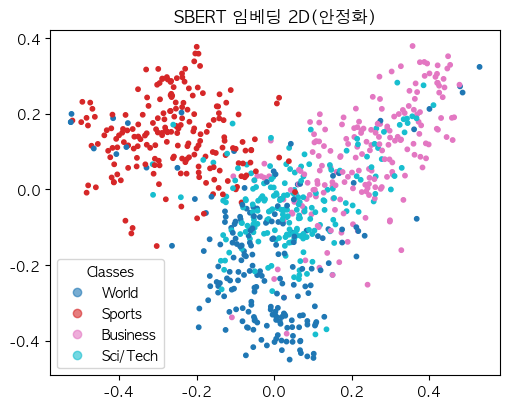

In [51]:
# =========================
# PCA 2D 투영 (샘플링 + 수치 안정화)
# =========================

# -------------------------
# 1) 데이터 샘플링
# -------------------------
# - 시각화에 모든 데이터를 쓰면 연산량이 크고 플롯이 복잡해짐
# - 최대 800개 샘플만 랜덤 추출하여 PCA 수행
sub_n = min(800, Xtr_emb.shape[0])  
idx = np.random.choice(np.arange(Xtr_emb.shape[0]), size=sub_n, replace=False)

# 선택된 샘플만 추출 (float64로 변환 → PCA 안정성 확보)
X_for_pca = Xtr_emb[idx].astype(np.float64)

# -------------------------
# 2) 차원 축소 (PCA → 2차원)
# -------------------------
try:
    # 일반 PCA 수행 (full SVD 방식 → 안정적이지만 메모리 소모 큼)
    emb2d = PCA(n_components=2, svd_solver='full').fit_transform(X_for_pca)
except Exception as e:
    # PCA 실패 시 (메모리 부족, 수치 불안정 등)
    # TruncatedSVD(근사적 SVD)를 사용하여 대체
    print("PCA(full) 실패 — TruncatedSVD로 대체:", e)
    from sklearn.decomposition import TruncatedSVD
    emb2d = TruncatedSVD(
        n_components=2, n_iter=7, random_state=42
    ).fit_transform(X_for_pca)

plt.figure(figsize=(5.2, 4.2))

# 산점도 그릴 때 label 지정
scatter = plt.scatter(
    emb2d[:, 0], emb2d[:, 1],
    c=np.array(y_train)[idx],
    s=10,
    cmap="tab10"   # 10가지 색 팔레트 (클래스가 4개여도 자동 매핑됨)
)

# 클래스별 legend 생성
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
plt.legend(handles, label_names, title="Classes", loc="best")

plt.title("SBERT 임베딩 2D(안정화)")
plt.tight_layout()
plt.show()


#### SBERT 임베딩 2D 시각화 해석

##### 클래스별 분포
- **World (파란색)**  
  - 그래프 왼쪽 아래쪽에 밀집된 군집 형성  
  - 다른 클래스와 비교적 잘 분리됨  
  - → SBERT가 세계 뉴스 문장을 의미적으로 잘 구분하고 있음을 시사  

- **Sports (빨간색)**  
  - 왼쪽 위쪽에 크게 모여 있는 군집  
  - World, Business와 일부 접점은 있지만 대부분 뚜렷하게 분리  
  - → 스포츠 기사 특유의 단어가 강하게 반영되어 잘 구분됨  

- **Business (분홍색)**  
  - 오른쪽 위쪽에 퍼져 있는 군집  
  - Sci/Tech(하늘색)과 경계가 겹치는 부분이 많음  
  - → 실제 혼동행렬에서 Business ↔ Sci/Tech 오분류가 많았던 현상과 일치  

- **Sci/Tech (하늘색)**  
  - 오른쪽 아래쪽에 분포  
  - Business와 섞인 부분 존재 → 기술·산업 기사의 경계 모호성 반영  
  - 일부는 World와도 접점 → “국제 기술 뉴스” 같은 기사 때문일 수 있음  

---

##### 성능 인사이트
- **Sports, World** : 뚜렷한 군집 형성 → 분류 성능이 높음  
- **Business, Sci/Tech** : 분포가 겹쳐 경계가 불명확 → 모델이 혼동하기 쉬움  
- 이는 TF-IDF 혼동행렬 해석과도 일관된 결과  

---

##### 결론
- SBERT는 텍스트 의미를 잘 반영해 **Sports·World는 뚜렷하게 분리**함.  
- **Business·Sci/Tech는 내용적 중첩이 크기 때문에 구분이 어렵다**는 점이 시각적으로 확인됨.  
- 단, 이 결과는 2D 투영(PCA) 시각화이므로 **고차원 공간(384차원)에서는 더 잘 분리될 가능성**이 있음 → 2D 결과는 직관적 참고용으로 이해하는 것이 적절.


In [52]:
# =========================
# SBERT 임베딩 기반 로지스틱 회귀 분류
# =========================

# 로지스틱 회귀 분류기 정의
# - max_iter=200 : 학습 반복 횟수
# - solver="saga" : 대규모/희소 행렬에서도 잘 동작하는 최적화 알고리즘
clf_emb = LogisticRegression(max_iter=200, solver="saga")

# -------------------------
# 모델 학습
# -------------------------
with timer("SBERT+LR 학습"):
    # SBERT 임베딩(Xtr_emb)을 입력으로 사용해 로지스틱 회귀 학습
    clf_emb.fit(Xtr_emb, y_train)

[TIME] SBERT+LR 학습: 0.39s


In [53]:
# -------------------------
# 예측 및 평가
# -------------------------
# 검증 데이터셋(Xva_emb)으로 클래스 예측
pred_sbert = clf_emb.predict(Xva_emb)

# 정확도 계산
acc_sbert = accuracy_score(y_val, pred_sbert)
print(f"SBERT+LR | acc={acc_sbert:.3f}")

# 정밀도, 재현율, F1-score 출력 (클래스별)
print(classification_report(y_val, pred_sbert, target_names=label_names))

SBERT+LR | acc=0.870
              precision    recall  f1-score   support

       World       0.83      0.78      0.80        50
      Sports       0.86      0.98      0.92        50
    Business       0.88      0.90      0.89        50
    Sci/Tech       0.91      0.82      0.86        50

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



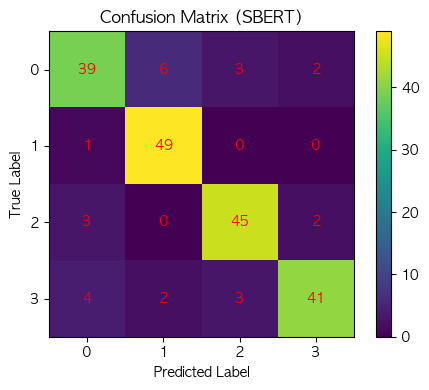

In [55]:
# =========================
# 혼동 행렬 (Confusion Matrix) 시각화 - SBERT
# =========================

# 혼동 행렬 계산
cm_sbert = confusion_matrix(y_val, pred_sbert)

# Figure 크기 설정
plt.figure(figsize=(5, 4))

# 혼동 행렬을 이미지(heatmap)처럼 출력
plt.imshow(cm_sbert, cmap="viridis")
plt.title("Confusion Matrix (SBERT)")  # 제목
plt.colorbar()  # 색상바 추가 → 값 크기 직관적으로 확인 가능

# 축 라벨 설정 (0 ~ 클래스 수-1)
classes = range(cm_sbert.shape[0])
plt.xticks(classes, classes)  # X축 (예측 클래스)
plt.yticks(classes, classes)  # Y축 (실제 클래스)

# 축 이름 붙이기
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 셀 안 숫자 출력
for i in range(cm_sbert.shape[0]):
    for j in range(cm_sbert.shape[1]):
        plt.text(j, i, str(cm_sbert[i, j]),
                 ha='center', va='center', color="red")

# 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()



#### SBERT 혼동행렬 결과 해석

##### 클래스별 해석
- **클래스 0 (World)**  
  - 39개 올바르게 분류  
  - 6개는 Sports(1), 3개는 Business(2), 2개는 Sci/Tech(3)으로 오분류  
  - → 약간의 오분류가 있지만 대체로 잘 구분됨  

- **클래스 1 (Sports)**  
  - 49개 정확히 맞춤, 단 1개만 World(0)으로 잘못 분류  
  - → 거의 완벽한 분류 성능  

- **클래스 2 (Business)**  
  - 45개 올바르게 분류  
  - 3개는 World(0), 2개는 Sci/Tech(3)으로 오분류  
  - → 이전 TF-IDF 때보다 더 잘 맞음 (특히 Sci/Tech과 혼동이 줄어듦)  

- **클래스 3 (Sci/Tech)**  
  - 41개 정확히 분류  
  - 약 9개는 다른 클래스(특히 World=4, Business=3)로 혼동  
  - → 여전히 Business와의 경계가 애매한 부분 존재  

---

##### 성능 요약
- **Sports (1)** : 거의 완벽 (TF-IDF와 동일하거나 더 나음)  
- **World (0)** : 소수 오분류 있으나 여전히 안정적  
- **Business (2)** : TF-IDF 대비 오분류가 크게 줄어 개선됨  
- **Sci/Tech (3)** : Business/World와 일부 혼동, TF-IDF보다 약간 더 안정적이나 경계가 여전히 모호  

---

##### 인사이트
- SBERT는 TF-IDF 대비 **Business ↔ Sci/Tech 구분력이 확실히 개선됨**  
- 여전히 Sci/Tech은 다른 클래스와 경계가 섞이지만, 전반적인 분류 성능은 향상됨  
- 특히 **Sports**처럼 뚜렷한 도메인의 경우는 거의 완벽하게 분류됨  


### 4. 하이퍼파라미터 스윕 
- TF‑IDF: ngram, C
- SBERT+LR: C (임베딩은 고정)


In [ ]:
# =========================
# 간단 스윕: TF-IDF ngram_range / C
# =========================
from sklearn.model_selection import ParameterGrid

# -------------------------
# 1) 탐색할 파라미터 조합 정의
# -------------------------
# - ngram_range:
#   (1,1) → unigram (단어 하나씩만 고려)
#   (1,2) → unigram + bigram (단어 하나 + 단어 쌍까지 고려)
#   → n-gram 범위를 확장하면 문맥 정보를 더 반영할 수 있지만,
#      차원이 커지고 과적합 위험도 증가할 수 있음
#
# - C (정규화 강도 inverse 값):
#   LogisticRegression에서 정규화 계수 λ = 1/C
#   C ↓ (작을수록) → 정규화 강도 ↑ → 규제가 강해져 단순한 모델 (과적합 방지)
#   C ↑ (클수록) → 정규화 강도 ↓ → 규제가 약해져 모델이 더 유연 (과적합 위험)
params = list(ParameterGrid({
    'ngram_range': [(1,1),(1,2)],
    'C': [0.5, 1.0, 2.0],
}))

In [ ]:
best = None  # 최고 성능 기록용

# -------------------------
# 2) TF-IDF + LR 하이퍼파라미터 탐색
# -------------------------
for p in params:
    # TF-IDF 벡터라이저 정의
    vec = TfidfVectorizer(max_features=30000, ngram_range=p['ngram_range'])
    Xtr_ = vec.fit_transform(X_train)
    Xva_ = vec.transform(X_val)

    # 로지스틱 회귀 분류기 (C 값 조정)
    clf_ = LogisticRegression(max_iter=200, C=p['C'])
    clf_.fit(Xtr_, y_train)

    # 정확도 평가
    acc_ = accuracy_score(y_val, clf_.predict(Xva_))
    row = (acc_, p)

    # 최고 성능 갱신
    if not best or acc_ > best[0]:
        best = row

    print('TF-IDF', p, 'acc=', round(acc_,3))

print('Best TF-IDF:', best)  # 최고 성능 하이퍼파라미터 출력


In [ ]:
# -------------------------
# 3) SBERT + LR 하이퍼파라미터 탐색 (C만 조정)
# -------------------------
# - SBERT 임베딩은 이미 구해둔 상태(Xtr_emb, Xva_emb)
# - 따라서 ngram_range 같은 전처리 변화는 불필요 → C만 변경
for C in [0.5, 1.0, 2.0]:
    clf_ = LogisticRegression(max_iter=200, C=C)
    clf_.fit(Xtr_emb, y_train)
    acc_ = accuracy_score(y_val, clf_.predict(Xva_emb))
    print('SBERT+LR', {'C': C}, 'acc=', round(acc_,3))



TF-IDF {'C': 0.5, 'ngram_range': (1, 1)} acc= 0.865
TF-IDF {'C': 0.5, 'ngram_range': (1, 2)} acc= 0.84
TF-IDF {'C': 1.0, 'ngram_range': (1, 1)} acc= 0.875
TF-IDF {'C': 1.0, 'ngram_range': (1, 2)} acc= 0.855
TF-IDF {'C': 2.0, 'ngram_range': (1, 1)} acc= 0.89
TF-IDF {'C': 2.0, 'ngram_range': (1, 2)} acc= 0.87
Best TF-IDF: (0.89, {'C': 2.0, 'ngram_range': (1, 1)})
SBERT+LR {'C': 0.5} acc= 0.87
SBERT+LR {'C': 1.0} acc= 0.87
SBERT+LR {'C': 2.0} acc= 0.86


#### TF-IDF vs SBERT 하이퍼파라미터 스윕 결과

##### TF-IDF + Logistic Regression
- **C 값 증가 → 성능 개선**
  - C=0.5 → acc = 0.865  
  - C=1.0 → acc = 0.875  
  - C=2.0 → acc = 0.890 (**최고 성능**)  
- **ngram_range**
  - (1,1) → 성능이 더 안정적으로 높음  
  - (1,2) → bigram 포함 시 오히려 약간 성능 저하  
- 결론: **unigram + 약한 정규화(C=2.0)** 조합이 가장 효과적

##### SBERT + Logistic Regression
- C=0.5 → acc = 0.870  
- C=1.0 → acc = 0.870  
- C=2.0 → acc = 0.860  
- 정규화 강도(C 값)에 따른 성능 변화가 거의 없음  
- 결론: **SBERT는 하이퍼파라미터에 덜 민감하며 안정적 성능 유지**

---

##### TF-IDF vs SBERT 비교
| 모델              | 최고 성능 (Accuracy) | 최적 파라미터 |
|-------------------|----------------------|---------------|
| **TF-IDF + LR**   | **0.890**           | C=2.0, ngram=(1,1) |
| **SBERT + LR**    | 0.870               | C=0.5 또는 1.0 |

- TF-IDF가 약간 더 높은 정확도를 기록 (≈ +2%p)  
- SBERT는 파라미터 변화에 덜 민감하고 안정적인 결과 제공  

---

##### 인사이트
1. **TF-IDF**: 특정 데이터셋에서는 여전히 강력. 튜닝을 잘하면 최신 임베딩보다 약간 우위 가능  
2. **SBERT**: 큰 튜닝 필요 없이 안정적 성능 확보. 특히 도메인 전환이나 의미 기반 태스크에서 강점  
3. **실무적 시사점**:  
   - 작은 데이터셋 + 특정 도메인 → TF-IDF가 유리할 수 있음  
   - 다양한 도메인 + 의미 유사도 중요 → SBERT가 더 적합


### 5. 추론 속도 비교 (샘플 N개)
- TF‑IDF vs SBERT 파이프라인

In [58]:
# =========================
# 추론 속도 벤치마크 함수
# =========================
def bench_inference(n=128):
    """
    TF-IDF + LR vs SBERT + LR 추론 속도를 비교하는 함수

    Args:
        n (int): 검증 데이터에서 추출할 샘플 개수 (기본=128)

    Returns:
        dict: { 'n': 샘플 수, 'tfidf_sec': TF-IDF 예측 시간, 'sbert_sec': SBERT 예측 시간 }
    """
    # -------------------------
    # 1) 샘플링
    # -------------------------
    samp = X_val[:n]   # 검증 데이터 앞에서 n개만 추출
    
    # -------------------------
    # 2) TF-IDF + LR 추론 시간 측정
    # -------------------------
    t0 = time.perf_counter()
    _ = clf_tfidf.predict(vectorizer.transform(samp))  # TF-IDF 벡터화 → 분류
    t_tfidf = time.perf_counter() - t0
    
    # -------------------------
    # 3) SBERT + LR 추론 시간 측정
    # -------------------------
    t0 = time.perf_counter()
    _ = clf_emb.predict(sbert_encode(samp))  # SBERT 임베딩 생성 → 분류
    t_sbert = time.perf_counter() - t0
    
    # -------------------------
    # 4) 결과 출력
    # -------------------------
    print({
        'n': n,
        'tfidf_sec': round(t_tfidf, 3),   # TF-IDF 추론에 걸린 초 단위 시간
        'sbert_sec': round(t_sbert, 3)    # SBERT 추론에 걸린 초 단위 시간
    })


# -------------------------
# 함수 실행 예시
# -------------------------
bench_inference(64)   # 검증 데이터 64개 샘플 기준 속도
bench_inference(128)  # 검증 데이터 128개 샘플 기준 속도



{'n': 64, 'tfidf_sec': 0.012, 'sbert_sec': 5.31}
{'n': 128, 'tfidf_sec': 0.02, 'sbert_sec': 6.856}


#### 추론 속도 비교 (TF-IDF vs SBERT)

##### 결과 요약
- **n=64 샘플**
  - TF-IDF+LR: **0.012초**
  - SBERT+LR: **5.31초**
- **n=128 샘플**
  - TF-IDF+LR: **0.020초**
  - SBERT+LR: **6.856초**

---

##### 해석

1. **TF-IDF + LR**
   - 샘플 수가 2배(64 → 128) 늘어나자, 추론 시간도 거의 2배(0.012 → 0.020) 증가 → **선형 확장**  
   - 매우 빠른 속도로 추론 가능 (밀리초 단위)

2. **SBERT + LR**
   - 64개: 5.31초, 128개: 6.856초  
   - 샘플 수가 2배로 늘었지만 시간은 약 +1.5초만 증가 → **배치 처리 특성**  
   - 기본 추론 시간이 크고 CPU에서 동작하기 때문에 속도는 느림

---

##### 성능 비교
- **속도**: TF-IDF ≫≫ SBERT  
- **스케일링**:  
  - TF-IDF → 샘플 수에 정비례 (O(n))  
  - SBERT → 배치 처리 덕분에 완만하게 증가하지만, 기본 비용이 매우 큼  

---

##### 인사이트
- **실시간 추론/대규모 배치**: TF-IDF가 적합  
- **의미 기반 정확도/일반화**: SBERT가 더 유리하지만 속도 병목 발생  
- **실무 활용 가이드**:  
  - 속도 우선 → TF-IDF 또는 경량 모델(DistilBERT, Sentence-T5)  
  - 정확도 우선 → SBERT + GPU/ONNX 최적화 필요
